In [1]:
import urllib.request
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import numpy as np
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import os
import json
import sys
from csv import reader
from csv import writer
from scipy.integrate import odeint

In [2]:
def download_data(url_dictionary):
    #Lets download the files
    for url_title in url_dictionary.keys():
        urllib.request.urlretrieve(url_dictionary[url_title], "./data/" + url_title)

In [3]:
def load_json(json_file_str):
    # Loads  JSON into a dictionary or quits the program if it cannot.
    try:
        with open(json_file_str, "r") as json_file:
            json_variable = json.load(json_file)
            return json_variable
    except Exception:
        sys.exit("Cannot open JSON file: " + json_file_str)

In [4]:
def sumCases_province(input_file, output_file):
    with open(input_file, "r") as read_obj, open(output_file, 'w', newline='') as write_obj:
        csv_reader = reader(read_obj)
        csv_writer = writer(write_obj)

        lines = []
        for line in csv_reader:
            lines.append(line)

        i = 0
        ix = 0
        for i in range(0, len(lines[:]) - 1):
            if lines[i][1] == lines[i + 1][1]:
                if ix == 0:
                    ix = i
                lines[ix][4:] = np.asfarray(lines[ix][4:], float) + np.asfarray(lines[i + 1][4:], float)
            else:
                if not ix == 0:
                    lines[ix][0] = ""
                    csv_writer.writerow(lines[ix])
                    ix = 0
                else:
                    csv_writer.writerow(lines[i])
            i += 1


In [5]:
data_d = load_json("./data_url.json")
download_data(data_d)

In [6]:
sumCases_province('data/time_series_19-covid-Confirmed.csv', 'data/time_series_19-covid-Confirmed-country.csv')
sumCases_province('data/time_series_19-covid-Recovered.csv', 'data/time_series_19-covid-Recovered-country.csv')
sumCases_province('data/time_series_19-covid-Deaths.csv', 'data/time_series_19-covid-Deaths-country.csv')

In [50]:
data_confirmed = pd.read_csv('data/time_series_19-covid-Confirmed-country.csv')
data_recovered = pd.read_csv('data/time_series_19-covid-Recovered-country.csv')
data_deaths = pd.read_csv('data/time_series_19-covid-Deaths-country.csv')


In [104]:
def savePlot(strFile):
    if os.path.isfile(strFile):
        os.remove(strFile)  # Opt.: os.system("del "+strFile)
    plt.savefig(strFile, dpi=600)


class Learner(object):
    def __init__(self, loss, country, start_date, predict_range, s_0, i_0, r_0):
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0
        self.country = country

    def load_confirmed(self):
        df = pd.read_csv('data/time_series_19-covid-Confirmed-country.csv')
        country_df = df[df['Country/Region'] == self.country]
        return country_df.iloc[0].loc[self.start_date:'3/19/21']

    def load_recovered(self):
        df = pd.read_csv('data/time_series_19-covid-Recovered-country.csv')
        country_df = df[df['Country/Region'] == self.country]
        return country_df.iloc[0].loc[self.start_date:'3/19/21']

    def load_dead(self):
        df = pd.read_csv('data/time_series_19-covid-Deaths-country.csv')
        country_df = df[df['Country/Region'] == self.country]
        return country_df.iloc[0].loc[self.start_date:'3/19/21']

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')

        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, death,healed, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)

        def SIR(y, t):
            S = y[0]
            I = y[1]
            R = y[2]
            y0 = -beta * S * I
            y1 = beta * S * I - gamma * I
            y2 = gamma * I

            return [y0, y1, y2]

        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        extended_healed = np.concatenate((healed.values, [None] * (size - len(healed.values))))
        y0=[s_0,i_0,r_0]
        tspan=np.arange(0, size, 1)
        res=odeint(SIR,y0,tspan)

        optimal = minimize(loss2, gamma*0.02, args=(gamma, recovered, healed, death),
                          bounds=[(0.00000001, gamma),])
        print(optimal)
        a = optimal.x[0]

        prediction_death = a * res[:,2]/gamma
        prediction_healed = res[:,2] - prediction_death
        y0=res[:,0]
        y1=res[:,1]
        y2=res[:,2]

        return new_index, extended_actual, extended_recovered, extended_death, y0, y1, y2, prediction_death, prediction_healed, extended_healed

    def train(self):
        self.healed = self.load_recovered()
        self.death = self.load_dead()
        self.recovered = self.healed + self.death
        self.data = (self.load_confirmed() - self.recovered)
        optimal = minimize(loss, [0.001, 0.001], args=(self.data, self.recovered, self.s_0, self.i_0, self.r_0),
                           method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, gamma = optimal.x
        self.optimal_beta = beta
        self.optimal_gamma = gamma

    def plot(self):
        beta = self.optimal_beta
        gamma = self.optimal_gamma
        death = self.death
        healed = self.healed
        recovered = self.recovered
        data = self.data

        new_index, extended_actual, extended_recovered, extended_death, y0, y1, y2, prediction_death, prediction_healed, extended_healed = self.predict(beta, gamma, data, recovered, death, healed, self.s_0, self.i_0, self.r_0)

        df = pd.DataFrame({'Infected data': extended_actual,
                            'Death data': extended_death,
                            'Susceptible': y0,
                            'Infected': y1,
                            'Predicted Recovered (Alive)': prediction_healed,
                            'Predicted Deaths': prediction_death,
                            'Recovered (Alive)': extended_healed},
                            index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
        fig.savefig(self.country + '.png')
        return df


def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point

    def SIR(y, t):
        S = y[0]
        I = y[1]
        R = y[2]
        y0 = -beta * S * I
        y1 = beta * S * I - gamma * I
        y2 = gamma * I
        return [y0, y1, y2]

    y0=[s_0,i_0,r_0]
    tspan=np.arange(0, size, 1)
    res=odeint(SIR,y0,tspan)
    l1 = np.sqrt(np.mean((res[:,1] - data)**2))
    l2 = np.sqrt(np.mean((res[:,2] - recovered)**2))

    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

def loss2(a, gamma, recovered, healed, death):

    estimated_death = a * (recovered / gamma)
    estimated_healed = recovered - estimated_death

    l1 = np.sqrt(np.mean((estimated_death - death)**2))
    l2 = np.sqrt(np.mean((estimated_healed - healed)**2))

    alpha = 0.9
    return alpha*l1 + (1-alpha)*l2

      fun: 702801.5776451589
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.        , 0.38417056])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 6
     njev: 24
   status: 0
  success: True
        x: array([0.37122016, 0.00784825])
      fun: 19136.243986510974
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00145519])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 14
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([0.00035618])
country=Italy, beta=0.37122016, gamma=0.00784825, r_0:47.29974746


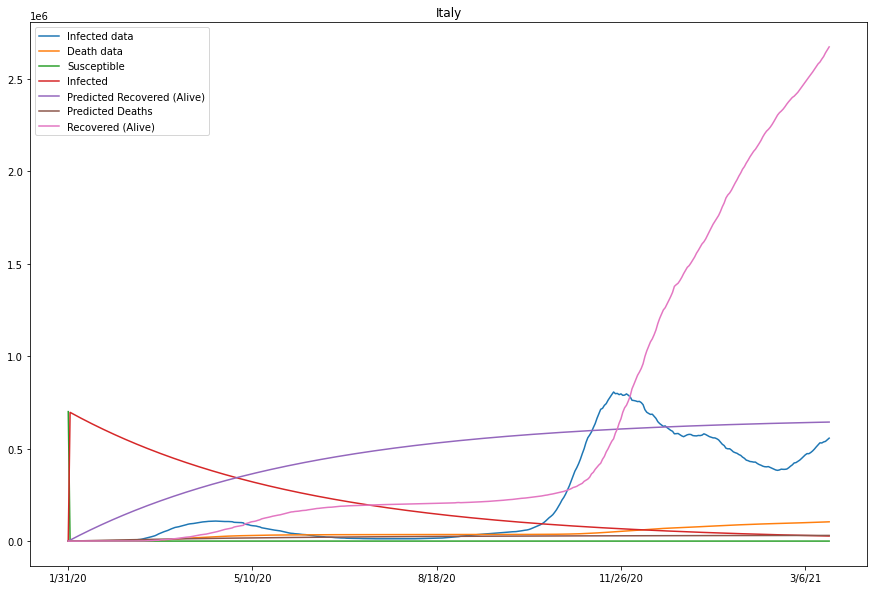

In [106]:
learner = Learner(loss, 'Italy', '1/31/20', 150, 700000, 1500, 0)
learner.train()
df = learner.plot()

In [78]:
df

,Infected data,Death data,Susceptible,Infected,Predicted Recovered (Alive),Predicted Deaths,Recovered (Alive)
1/31/20,0.0,0.0,300000.000000,1500.000000,0.0,10.000000,0.0
2/1/20,1.0,0.0,299971.041275,1528.115896,0.0,10.842829,0.0
2/2/20,1.0,0.0,299941.542658,1556.755887,0.0,11.701455,0.0
2/3/20,1.0,0.0,299911.494189,1585.929639,0.0,12.576172,0.0
2/4/20,1.0,0.0,299880.885733,1615.646986,0.0,13.467281,0.0
...,...,...,...,...,...,...,...
12/15/20,333515.0,7514.0,102497.332657,189626.126390,0.0,9386.540954,0.0
12/16/20,340783.0,7802.0,101261.890941,190755.691349,0.0,9492.417710,0.0
12/17/20,349573.0,7893.0,100034.162181,191876.916857,0.0,9598.920962,0.0
12/18/20,359127.0,7993.0,98814.280916,192989.673053,0.0,9706.046032,0.0


In [52]:
data_deaths[data_deaths['Country/Region'] == 'Italy']['6/28/20']

85    34738.0
Name: 6/28/20, dtype: float64

85    181228.0
Name: 4/20/20, dtype: float64